# How to use Refactored WEAC_2

In [1]:
import os
import sys
# Third party imports=
import numpy as np
import matplotlib.pyplot as plt

# Project imports
import weac_2

### Define slab layering
---

#### i) from database
Choose one of the following profiles (a-f) from the database

<img src="../img/profiles.png" width="500"/>

where the illustrated bar lengths correspond to the following densities of the layers (longer is denser): 

| Type   | Density    |
|--------|------------|
| Soft   | 180 kg/m^3 |
| Medium | 270 kg/m^3 |
| Hard   | 350 kg/m^3 |

Layers of the database profile are 120 mm thick.

#### ii) define a custom slab profile

Define a custom slab profile as a 2D array where the columns are density (kg/m^2) and layer thickness (mm). One row corresponds to one layer counted from top (below surface) to bottom (above weak layer):

<img src="../img/layering.png" width="250"/>

In [2]:
from weac_2.components import Layer, Config, ScenarioConfig, ModelInput, WeakLayer, Segment
from weac_2.utils import load_dummy_profile




# # Skiers on B Profile
# skiers_on_b_layers = load_dummy_profile('b')
# skiers_config = ScenarioConfig(
#     system='skiers',
#     phi=30,
# )
# skiers_on_b_input = ModelInput(
#     scenario_config=skiers_config,
#     layers=skiers_on_b_layers,
# )


### Create model instances
---

In [3]:
from weac_2.core.system_model import SystemModel


# # Multiple skiers on slab with database profile B
# skiers_on_B = SystemModel(
#     model_input=skiers_on_b_input,
# )

### Inspect layering
---

In [4]:
from weac_2.analysis.plotter import Plotter


### Analyze skier-induced stresses and deformations
---

In [5]:
# Example with two segements, one skier load
# (between segments 1 & 2) and no crack.

#                   |
#                   v
# +-----------------+-----------------+
# |                 |                 |
# |        1        |        2        |
# |                 |                 |
# +-----------------+-----------------+
#  |||||||||||||||||||||||||||||||||||
# --------------------------------------

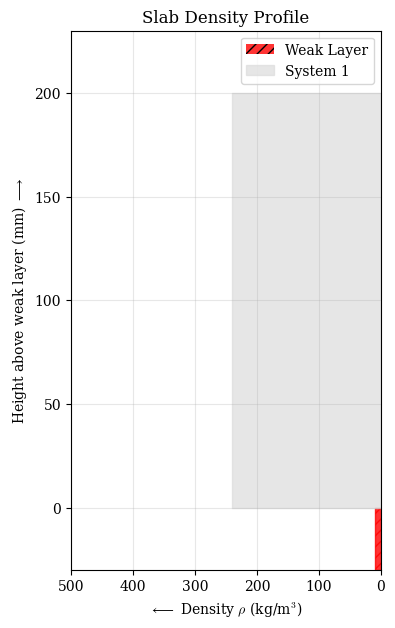

In [6]:
from weac_2.analysis.analyzer import Analyzer

# Default slab profile
default_slab_layers = [
    Layer(rho=240, h=200),
]
skier_config = ScenarioConfig(
    system_type='skier',
    phi=30,
)
skier_segments = [
    Segment(length=5000, has_foundation=True, m=0),
    Segment(length=0, has_foundation=False, m=80),
    Segment(length=0, has_foundation=False, m=00),
    Segment(length=5000, has_foundation=True, m=0),
]
skier_input = ModelInput(
    scenario_config=skier_config,
    layers=default_slab_layers,
    segments=skier_segments,
)
# One skier on homogeneous default slab (240 kg/m^3, 200 mm)
skier_model = SystemModel(
    model_input=skier_input,
)


skier_plotter = Plotter(skier_model)
fig = skier_plotter.plot_slab_profile()

skier_analyzer = Analyzer(skier_model)
xsl_skier, z_skier, xwl_skier = skier_analyzer.rasterize_solution()


#### Visualize slab deformations (contour plot)

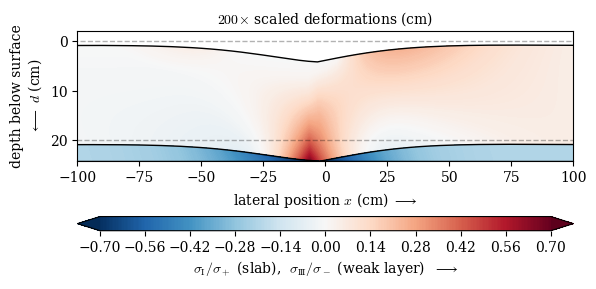

In [7]:
skier_plotter.plot_deformed(xsl_skier, xwl_skier, z_skier, skier_analyzer, scale=200, window=200, aspect=2, field='principal')

#### Plot slab displacements

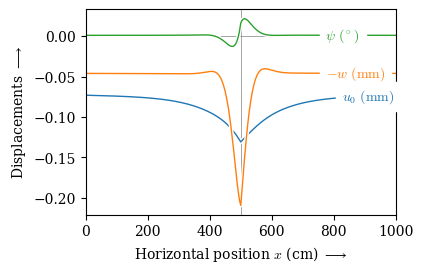

In [8]:
skier_plotter.plot_displacements(skier_analyzer, x=xsl_skier, z=z_skier)

#### Plot weak-layer stresses

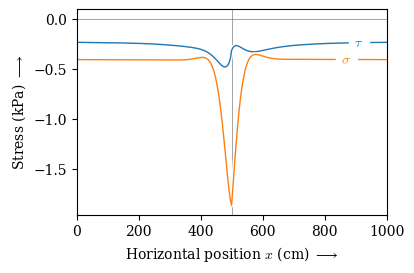

In [9]:
skier_plotter.plot_stresses(skier_analyzer, x=xwl_skier, z=z_skier)

### Propagation saw test
---

In [10]:
# Example with a crack cut from the right-hand side.

# +-----------------------------+-----+
# |                             |     |
# |             1               |  2  |
# |                             |     |
# +-----------------------------+-----+
#  |||||||||||||||||||||||||||||
# --------------------------------------

In [11]:
# PST Profile
pst_layers = [
    Layer(rho=170, h=100),
    Layer(rho=190, h=40),
    Layer(rho=230, h=130),
    Layer(rho=250, h=20),
    Layer(rho=210, h=70),
    Layer(rho=380, h=20),
    Layer(rho=280, h=100),
]
pst_config = ScenarioConfig(
    system_type='pst-',
    phi=-38,
    crack_length=300,
)
pst_segments = [
    Segment(length=2200, has_foundation=True, m=0),
    Segment(length=300, has_foundation=False, m=0),
]
pst_input = ModelInput(
    scenario_config=pst_config,
    layers=pst_layers,
    segments=pst_segments,
)
pst_config = Config(
    touchdown=True,
)

pst_cut_right = SystemModel(
    model_input=pst_input,
    config=pst_config,
)

if pst_cut_right.slab_touchdown is not None:
    touchdown_distance = pst_cut_right.slab_touchdown.touchdown_distance
    print(f"Touchdown distance: {touchdown_distance} mm")
    touchdown_mode = pst_cut_right.slab_touchdown.touchdown_mode
    print(f"Touchdown mode: {touchdown_mode}")

pst_cut_right_analyzer = Analyzer(pst_cut_right)
xsl_pst, z_pst, xwl_pst = pst_cut_right_analyzer.rasterize_solution()
print(xsl_pst)


Touchdown distance: 300.0 mm
Touchdown mode: A_free_hanging
[   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.
  120.  130.  140.  150.  160.  170.  180.  190.  200.  210.  220.  230.
  240.  250.  260.  270.  280.  290.  300.  310.  320.  330.  340.  350.
  360.  370.  380.  390.  400.  410.  420.  430.  440.  450.  460.  470.
  480.  490.  500.  510.  520.  530.  540.  550.  560.  570.  580.  590.
  600.  610.  620.  630.  640.  650.  660.  670.  680.  690.  700.  710.
  720.  730.  740.  750.  760.  770.  780.  790.  800.  810.  820.  830.
  840.  850.  860.  870.  880.  890.  900.  910.  920.  930.  940.  950.
  960.  970.  980.  990. 1000. 1010. 1020. 1030. 1040. 1050. 1060. 1070.
 1080. 1090. 1100. 1110. 1120. 1130. 1140. 1150. 1160. 1170. 1180. 1190.
 1200. 1210. 1220. 1230. 1240. 1250. 1260. 1270. 1280. 1290. 1300. 1310.
 1320. 1330. 1340. 1350. 1360. 1370. 1380. 1390. 1400. 1410. 1420. 1430.
 1440. 1450. 1460. 1470. 1480. 1490. 1500. 1510. 1520. 1530. 154

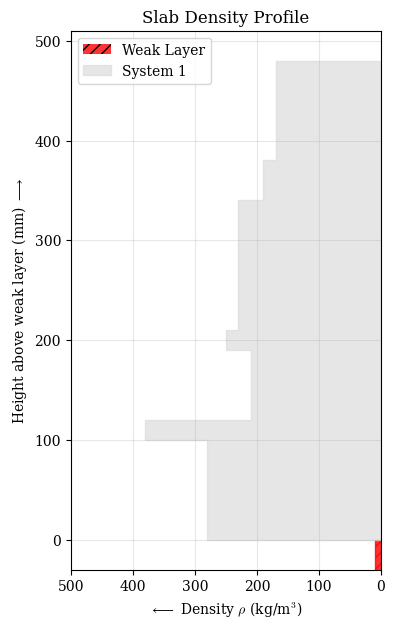

In [12]:
pst_cut_right_plotter = Plotter(pst_cut_right)
pst_cut_right_plotter.plot_slab_profile()

#### Visualize slab deformations (contour plot)

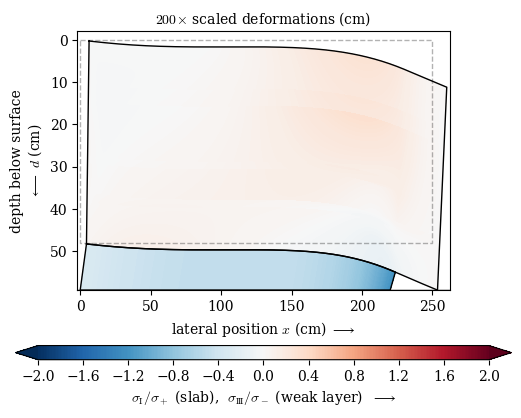

In [13]:
pst_cut_right_plotter.plot_deformed(xsl_pst, xwl_pst, z_pst, pst_cut_right_analyzer, scale=200, aspect=3, field='principal')

#### Plot slab deformations

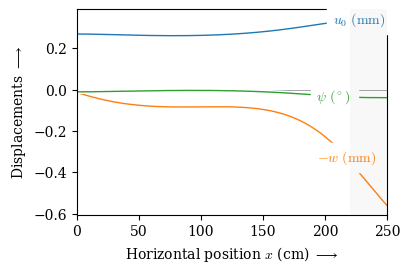

In [14]:
pst_cut_right_plotter.plot_displacements(pst_cut_right_analyzer, x=xsl_pst, z=z_pst)

#### Plot weak-layer stresses

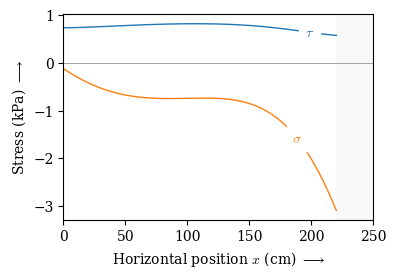

In [15]:
pst_cut_right_plotter.plot_stresses(pst_cut_right_analyzer, x=xwl_pst, z=z_pst)

In [16]:
Gdif = pst_cut_right_analyzer.differential_ERR()
Ginc = pst_cut_right_analyzer.incremental_ERR()
print("Gdif", Gdif)
print("Ginc", Ginc)

z [[ 3.35535978e-01]
 [ 5.70938135e-05]
 [ 3.47461392e-01]
 [ 7.14057828e-04]
 [-6.36904960e-04]
 [-4.10805194e-07]]
Gdif [5.85863470e-04 5.36575194e-04 4.92882758e-05]
Ginc [-9.13391029e-04 -8.76891957e-04 -3.64990718e-05]


### Energy release rate in propagation saw tests
---

In [17]:
inclination = 30                        # Slope inclination (°)
n = 50                                  # Number of crack increments

da = np.linspace(1e-6, 400, num=n)
Gdif = np.zeros([3, n])
Ginc = np.zeros([3, n])

for i in range(n):
    L = 1200 - da[i]
    pst_ERR_segments = [
        Segment(length=L, has_foundation=True, m=0),
        Segment(length=da[i], has_foundation=False, m=0),
    ]
    pst_cut_right.update_scenario(
        segments=pst_ERR_segments,
        phi=inclination,
    )
    pst_cut_right_analyzer = Analyzer(pst_cut_right)
    Gdif[:, i] = pst_cut_right_analyzer.differential_ERR()
    Ginc[:, i] = pst_cut_right_analyzer.incremental_ERR()

print(Gdif)

[[9.88193727e-01 9.64325750e-01 9.40932049e-01 9.18016136e-01
  8.95580230e-01 8.73625349e-01 8.52151410e-01 8.31157310e-01
  8.10641016e-01 7.90599646e-01 7.71029543e-01 7.51926355e-01
  7.33285101e-01 7.15100234e-01 6.97365709e-01 6.80075036e-01
  6.63221337e-01 6.46797394e-01 6.30795697e-01 6.15208489e-01
  6.00027805e-01 5.85245509e-01 5.70853328e-01 5.56842885e-01
  5.43205727e-01 5.29933349e-01 5.17017223e-01 5.04448814e-01
  4.92219605e-01 4.80321110e-01 4.68744893e-01 4.57482581e-01
  4.46525878e-01 4.35866573e-01 4.25496554e-01 4.15407816e-01
  4.05592464e-01 3.96042726e-01 3.86750955e-01 3.77709634e-01
  3.68911380e-01 3.60348949e-01 3.52015238e-01 3.43903284e-01
  3.36006270e-01 3.28317523e-01 3.20830518e-01 3.13538875e-01
  3.06436359e-01 2.99516884e-01]
 [9.87308578e-01 9.63606218e-01 9.40353288e-01 9.17556228e-01
  8.95219901e-01 8.73347717e-01 8.51941744e-01 8.31002815e-01
  8.10530632e-01 7.90523867e-01 7.70980251e-01 7.51896665e-01
  7.33269223e-01 7.15093350e-01 6.973

#### Plot differential energy release rate

In [ ]:
weac.plot.err_modes(da, Gdif, kind='dif')

### Multiple skiers
----

In [47]:
# Example with six segements, two skier loads (between
# segments 1 & 2 and 2 & 3) and a crack under segments
# 4 and 5

#           |   |
#           v   v
# +---------+---+-----+---+---+-------+
# |         |   |     |   |   |       |
# |    1    | 2 |  3  | 4 | 5 |   6   |
# |         |   |     |   |   |       |
# +---------+---+-----+---+---+-------+
#  |||||||||||||||||||         |||||||
# --------------------------------------

In [48]:
# Input
li = [5e3, 10e2, 25e2, 3e2, 3e2, 5e3]           # Beam segment lengths (mm)
ki = [True, True, True, False, False, True]     # Foundation (bedded/free = True/False)
mi = [80, 80, 0, 0, 0]                          # Skier weights [kg]
inclination = -20                               # Slope inclination (°)

# Obtain lists of segment lengths, locations of foundations,
# and position and magnitude of skier loads from inputs. If,
# in addition, a list k0 is passed to calc_segments, we may
# replace the 'crack' key by the 'nocrack' key to toggle
# between cracked (ki) and uncracked (k0) configurations.
seg_skiers = skiers_on_B.calc_segments(
    li=li, ki=ki, mi=mi)['crack']

# Assemble system of linear equations and solve the
# boundary-value problem for free constants.
C_skiers = skiers_on_B.assemble_and_solve(
    phi=inclination, **seg_skiers)

# Prepare the output by rasterizing the solution vector at all
# horizontal positions xsl (slab). The result is returned in the
# form of the ndarray z. Also provides xwl (weak layer) that only
# contains x-coordinates that are supported by a foundation.
xsl_skiers, z_skiers, xwl_skiers = skiers_on_B.rasterize_solution(
    C=C_skiers, phi=inclination, **seg_skiers)

#### Visualize slab deformations (contour plot)

In [ ]:
weac.plot.deformed(
    skiers_on_B, xsl=xsl_skiers, xwl=xwl_skiers, z=z_skiers,
    phi=inclination, window=1e3, scale=200, aspect=5,
    field='principal')

#### Plot slab displacements

In [ ]:
weac.plot.displacements(skiers_on_B, x=xsl_skiers, z=z_skiers, **seg_skiers)

#### Plot weak-layer stresses

In [ ]:
weac.plot.stresses(skiers_on_B, x=xwl_skiers, z=z_skiers, **seg_skiers)

#### Compare all outputs

In [ ]:
# === WEAK-LAYER OUTPUTS ===================================================

# Use only x-coordinates of bedded segments (xb)
x, z = xwl_skiers, z_skiers

# Compute stresses in kPa
xwl_cm, tau = skiers_on_B.get_weaklayer_shearstress(x=x, z=z, unit='kPa')
_, sig = skiers_on_B.get_weaklayer_normalstress(x=x, z=z, unit='kPa')

# === SLAB OUTPUTS ==========================================================

# Use x-coordinates of bedded and unsupported segments (xq)
x, z = xsl_skiers, z_skiers

# Compute deformations in um and degrees
xsl_cm, w = skiers_on_B.get_slab_deflection(x=x, z=z, unit='um')
_, u_top = skiers_on_B.get_slab_displacement(x=x, z=z, unit='um', loc='top')
_, u_mid = skiers_on_B.get_slab_displacement(x=x, z=z, unit='um', loc='mid')
_, u_bot = skiers_on_B.get_slab_displacement(x=x, z=z, unit='um', loc='bot')
_, psi = skiers_on_B.get_slab_rotation(x=x, z=z, unit='degrees')

# === ASSEMBLE ALL OUTPUTS INTO LISTS =======================================

outputs = [u_top, u_mid, u_bot, tau, psi, -w, sig]

names = [
    r'$u_\mathrm{top}\,(\mu\mathrm{m})$',
    r'$u_\mathrm{mid}\,(\mu\mathrm{m})$',
    r'$u_\mathrm{bot}\,(\mu\mathrm{m})$',
    r'$\tau\ (\mathrm{kPa})$',
    r'$\psi\ (\!^\circ\!)$',
    r'$-w\ (\mu\mathrm{m})$',
    r'$\sigma\ (\mathrm{kPa})$'
]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
coloridx = [0, 0, 0, 0, 2, 1, 1]

# === PLOT ALL OUTPUTS ======================================================

fig, axs = plt.subplots(7, 1, constrained_layout=True, figsize=(5,10))
for i, ax in enumerate(fig.get_axes()):
    ax.plot(xsl_cm, outputs[i], color=colors[coloridx[i]])
    ax.set_title(names[i])

### Checking criteria for anticrack nucleation and crack propagation

In [53]:
import sys
sys.path.append('../weac')  # Adds the 'weac' folder to the Python path

In [54]:
from criterion_check import *

In [ ]:
# Define test parameters
snow_profile = [[170, 100],  # (1) surface layer
             [190,  40],  # (2) 2nd layer
             [230, 130],  #  :
             [250,  20],  #  :
             [210,  70],  # (i) i-th layer
             [380,  20],  #  :
             [280, 100]]  # (N) last slab layer above weak layer

phi = 30  # Slope angle in degrees
skier_weight = 75  # Skier weight in kg
envelope = 'adam_unpublished'
scaling_factor = 1
E = 0.25  # Elastic modulus in MPa
order_of_magnitude = 1
density = 150  # Weak layer density in kg/m³
t = 30  # Weak layer thickness in mm

# Call the method
(
    result,
    crack_length,
    skier_weight,
    skier,
    C,
    segments,
    x_cm,
    sigma_kPa,
    tau_kPa,
    iteration_count,
    elapsed_times,
    skier_weights,
    crack_lengths,
    self_collapse,
    pure_stress_criteria,
    critical_skier_weight,
    g_delta_last,
    dist_max,
    g_delta_values,
    dist_max_values,
) = check_coupled_criterion_anticrack_nucleation(
    snow_profile=snow_profile,
    phi=phi,
    skier_weight=skier_weight,
    envelope=envelope,
    scaling_factor=scaling_factor,
    E=E,
    order_of_magnitude=order_of_magnitude,
    density=density,
    t=t,
)

# Print the results
print("Algorithm convergence:", result)
print("Anticrack nucleation governed by a pure stress criterion:", pure_stress_criteria)

print("Critical Skier Weight:", skier_weight, "kg")
print("Crack Length:", crack_length, "mm")
print("Fracture toughness envelope function:", g_delta_values[-1])
print("Stress failure envelope function:", dist_max_values[-1])

As the fracture toughness envelope function is greater than one for the minimum critical skier weight, this particular snow profile is governed by a pure stress criterion for anticrack nucleation. 

In [ ]:
# Define thinner snow profile (standard snow profile A), with higher weak layer Young's Modulus
snow_profile = [[350, 120],  # (1) surface layer
             [270,  120],  # (2) 2nd layer
             [180, 120]]  # (N) last slab layer above weak layer

phi = 30  # Slope angle in degrees
skier_weight = 75  # Skier weight in kg
envelope = 'adam_unpublished'
scaling_factor = 1
E = 1  # Elastic modulus in MPa
order_of_magnitude = 1
density = 150  # Weak layer density in kg/m³
t = 30  # Weak layer thickness in mm

(
    result,
    crack_length,
    skier_weight,
    skier,
    C,
    segments,
    x_cm,
    sigma_kPa,
    tau_kPa,
    iteration_count,
    elapsed_times,
    skier_weights,
    crack_lengths,
    self_collapse,
    pure_stress_criteria,
    critical_skier_weight,
    g_delta_last,
    dist_max,
    g_delta_values,
    dist_max_values,
) = check_coupled_criterion_anticrack_nucleation(
    snow_profile=snow_profile,
    phi=phi,
    skier_weight=skier_weight,
    envelope=envelope,
    scaling_factor=scaling_factor,
    E=E,
    order_of_magnitude=order_of_magnitude,
    density=density,
    t=t,
)

# Print the results
print("Algorithm convergence:", result)
print("Anticrack nucleation governed by a pure stress criterion:", pure_stress_criteria)

print("Critical Skier Weight:", skier_weight, "kg")
print("Crack Length:", crack_length, "mm")
print("Fracture toughness envelope function:", g_delta_values[-1])
print("Stress failure envelope function:", dist_max_values[-1])

The thinner snow profile, with adjusted weak layer Young's Modulus, is governed by a coupled criterion for anticrack nucleation. The critical skier weight is 346.7 kg and the associated crack length is 29 mm.

In [ ]:
# Evaluate crack propagation criterion for the found anticrack
g_delta_diff, crack_propagation_criterion_check = check_crack_propagation_criterion(
    snow_profile=snow_profile,
    phi=phi,
    segments=segments,
    skier_weight=0,
    E=E,
    t=t
)

# Print the results
print("Fracture toughness envelope function:", g_delta_diff)
print("Crack Propagation Criterion Met:", crack_propagation_criterion_check)

In [ ]:
# As the crack propagation criterion is not met --> investigate minimum self propagation crack boundary
initial_interval = (1, 3000)  # Interval for the crack length search (mm)

min_crack_length = find_min_crack_length_self_propagation(
    snow_profile=snow_profile,
    phi=phi,
    E=E,
    t=t,
    initial_interval=initial_interval
)

if min_crack_length is not None:
    print(f"Minimum Crack Length for Self-Propagation: {min_crack_length} mm")
else:
    print("The search for the minimum crack length did not converge.")

The anticrack of 29.0 mm is not sufficiently long to surpass the self crack propagation boundary of 1706.4 mm. The propensity of the generated anticrack to proagate, is low.

In [ ]:
# So far, stress envelope boundary has not scaled with weak layer density
# --> Update scaling factor using density baseline of 250 kg/m^3 and order of magnitude of 3, 
#     as this has shown closest resemblance to previously published failure envelopes

snow_profile = [[350, 120],  # (1) surface layer
             [270,  120],  # (2) 2nd layer
             [180, 120]]  # (N) last slab layer above weak layer

phi = 35  # Slope angle in degrees
skier_weight = 75  # Skier weight in kg
envelope = 'adam_unpublished'
E = 1 # Elastic modulus in MPa
order_of_magnitude = 3
density = 125  # Weak layer density in kg/m³
t = 30  # Weak layer thickness in mm
density_baseline = 250
scaling_factor = density / density_baseline

(
    result,
    crack_length,
    skier_weight,
    skier,
    C,
    segments,
    x_cm,
    sigma_kPa,
    tau_kPa,
    iteration_count,
    elapsed_times,
    skier_weights,
    crack_lengths,
    self_collapse,
    pure_stress_criteria,
    critical_skier_weight,
    g_delta_last,
    dist_max,
    g_delta_values,
    dist_max_values,
) = check_coupled_criterion_anticrack_nucleation(
    snow_profile=snow_profile,
    phi=phi,
    skier_weight=skier_weight,
    envelope=envelope,
    scaling_factor=scaling_factor,
    E=E,
    order_of_magnitude=order_of_magnitude,
    density=density,
    t=t,
)


print("Algorithm convergence:", result)
print("Anticrack nucleation governed by a pure stress criterion:", pure_stress_criteria)
print("Critical Skier Weight:", skier_weight, "kg")
print("Crack Length:", crack_length, "mm")
print("Fracture toughness envelope function:", g_delta_values[-1])
print("Stress failure envelope function:", dist_max_values[-1])

In [ ]:
# Evaluate crack propagation criterion for the found anticrack

g_delta_diff, crack_propagation_criterion_check = check_crack_propagation_criterion(
    snow_profile=snow_profile,
    phi=phi,
    segments=segments,
    skier_weight=0,
    E=E,
    t=t
)

print("Fracture toughness envelope function:", g_delta_diff)
print("Crack Propagation Criterion Met:", crack_propagation_criterion_check)

Crack propagation is expected given the anticrack nucleation length of 2343.7 mm. Scaling stress envelope boundary and weak layer Young's Modulus with weak layer density is essential for fair evaluation of anticrack and crack propagation criteria. 